No notebook anterior, nós aprendemos sobre o Perceptron. Vimos como ele aprende e como pode ser utilizado tanto para classificação binária quanto para regressão linear. Nesse notebook, nós veremos um algoritmo muito parecido com o Perceptron, mais conhecido como __Adaline__, que foi uma proposta de melhoria ao algoritmo original do Perceptron. Veremos as semelhanças e diferenças entre os dois algoritmos e iremos implementá-lo utilizando python, numpy, Tensorflow e Keras. Por fim, vamos aplicar nos mesmos problemas de classificação do notebook do Perceptron para entender de fato suas diferenças. __O código para utilizar o Adaline em problemas de regressão é exatamente o mesmo do Perceptron__.

__Objetivos__:

- Entender as diferenças entre os algoritmos do Perceptron e Adaline.
- Implementar o Adaline e seu modelo de aprendizado em Python puro e numpy
- Utilizar o Adaline para classificação e regressão.

# Sumário

[Introdução](#Introdução)

[Regra de Aprendizado do Adaline](#Regra-de-Aprendizado-do-Adaline)

[Classificação](#Classificação)
- [Porta AND/OR](#Porta-AND/OR)
- [Exercício de Classificação](#Exerc%C3%ADcio-de-Classificação)

# Imports e Configurações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sb
from random import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

# Introdução

Poucos meses após a publicação do teorema da convergência do Perceptron por Rosenblatt, os engenheiros da Universidade de Stanford Bernard Widrow e Marcian Hoff publicaram um trabalho descrevendo uma rede neural muito parecida com o Perceptron, a __Adaline__ (do inglês _ADAptive LINear Element_). Porém, ao invés de utilizar a função _step_ como função de ativação, a __Adaline utiliza função de ativação linear e tem uma nova regra de aprendizado supervisionado__, conhecida como __regra de Widrow-Hoff__ (ou __regra delta__, ou ainda __regra LMS__). 

De fato, tanto o Perceptron quanto o Adaline possuem muitas características semelhantes e __é comum ver o pessoal confundindo o Perceptron com o Adaline__. Entre as principais semelhanças, podemos destacar:
- Ambos possuem __apenas um neurônio de N entradas e apenas uma saída. Não há camadas escondidas__.
- Ambos são __classificadores lineares binários__ por definição, mas podemos adaptá-los para efetuar __regressão linear__, da mesma forma como vimos no notebook sobre o Perceptron. __Na verdade, o código para treinar um Adaline para regressão é o mesmo de um Perceptron, só muda o modo como calculamos o custo__. No Adaline, o custo é dado pela soma dos erros quadrados (MSE), enquanto no Perceptron é dado pela soma dos erros.
- Ambos tem o **método de aprendizagem _online_**. Isto é, a atualização dos pesos é efetuada amostra por amostra.
- Ambos tem uma **função _step_ para classificação**. Porém, ao contrário do Perceptron, __na Adaline ela não é utilizada na atualização dos pesos__. Nós veremos por que a seguir.

Porém, a principal diferença entre o Perceptron e a Adaline é que o Perceptron utiliza os labels das classes para fazer a atualização dos pesos, enquanto __a Adaline utiliza o resultado da função de ativação (linear) como valor contínuo de predição__. Isto é, ao invés da saída ser discreta como no Perceptron (0 ou 1), __na Adaline a saída pode ser qualquer valor contínuo__. Essa diferença fica mais clara quando vemos a figura a seguir:

<img src="images/comparacao_perceptron_adaline.png">
[Fonte](https://www.quora.com/What-is-the-difference-between-a-Perceptron-Adaline-and-neural-network-model)

Repare, como dito, que ambos têm a função _step_. No Perceptron, ela é utilizada como função de ativação. No Adaline, por sua vez, a função de ativação é linear e a funcão _step_ é utilizada para gerar a predição. 

Por calcular a saída como um valor contínuo, __muitos consideram o Adaline mais poderoso__, uma vez que a diferença entre a saída desejada e o valor predito ($y_i - y_{pred_i}$) nos diz agora "o quanto estamos certos ou errados". __Na prática, isso faz com o que o Adaline tente encontrar a "melhor solução" para o problema, ao invés de somente uma "solução adequada"__. Tomando como exemplo a figura abaixo, o Perceptron pode encontrar diversas retas que separam as classes, enquanto o Adaline tenta encontrar a melhor reta que separa as classes.

<img src="images/hiperplanos_perceptron_adaline.png" width='700'>

[Fonte](http://www.barbon.com.br/wp-content/uploads/2013/08/RNA_Aula4.pdf)

Ok, mas como isso muda o aprendizado? É o que veremos a seguir.

## Regra de Aprendizado do Adaline

A atualização dos pesos do Adaline é dada pela mesma fórmula do Perceptron:

$$w_i = w_i + \lambda(y_i - y_{pred_i})x_i$$

Onde $\lambda$ é a __taxa de aprendizagem__.

Mas você já imaginou da onde vem essa fórmula? Em primeiro lugar, o método de atualização dos pesos é baseado na __Regra Delta__ (*Delta Rule*). Sendo $\overrightarrow{w} = \{w_1, w_2, ..., w_D\}$, a atualização dos pesos é dada por:

$$\overrightarrow{w} = \overrightarrow{w} - \Delta{\overrightarrow{w}}$$

em que:

$$\Delta{\overrightarrow{w}} = \lambda\nabla E(\overrightarrow{w})$$

Sendo $\nabla E(\overrightarrow{w})$ o gradiente de uma função que depende de $\overrightarrow{w}$ e que queremos minimizar.

No caso do Adaline, __a função de custo é dada pela soma dos erros quadrados__:

$$J(w) = \frac{1}{2}\sum_{i}^N (y_i - y_{pred_i})^2$$

Onde $N$ é a quantidade de amostras nos dados, e as demais variáveis representam as mesmas vistas anteriormente. Repare que a função de custo é quase uma _Mean Squared Error (MSE)_, só que ao invés de dividir por $N$, estamos dividindo por 2 o resultado do somatório. O por quê disso será entendido mais a frente na demonstração.

Queremos encontrar, então, o vetor $\overrightarrow{w}$ que minimiza a função $J$. Assim, temos:

$$\frac{\partial J}{\partial w_i} = \frac{\partial}{\partial w_i}\frac{1}{2}\sum_i^N (y_i - y_{pred_i})^2$$

Como a derivada do somatório é igual ao somatório das derivadas:

$$= \frac{1}{2}\sum_i^N \frac{\partial}{\partial w_i}(y_i - y_{pred_i})^2$$

Aplicando a regra da cadeia:

$$= \sum_i^N (y_i - y_{pred_i})\frac{\partial}{\partial w_i}(y_i - y_{pred_i})$$

Repare que, quando derivamos $(y_i - y_{pred_i})^2$, o expoente 2, ao sair do somatório, foi multiplicado por $\frac{1}{2}$, tornando-o 1. Isso é o que os matemáticos denominam de "conveniência matemática". 

Como $y_{pred_i} = x_iw_i + b$ é uma função que depende de $w$, e sua derivada em relação a $w_i$ é apenas $x_i$, temos que:

$$\frac{\partial J}{\partial w_i} = \sum_i^N (y_i - y_{pred_i})(-x_i)$$
$$\frac{\partial J}{\partial w_i} = -\sum_i^N (y_i - y_{pred_i})x_i$$

$$\frac{\partial J}{\partial \overrightarrow{w}} = -(\overrightarrow{y} - \overrightarrow{y}_{pred})\overrightarrow{x}$$

De maneira análoga, podemos calcular que a derivada de $J$ em relação a $b_i$ é:

$$\frac{\partial J}{\partial b_i} = -\sum_i^N (y_i - y_{pred_i})*1.0$$

Já que a derivada de $y_{pred_i}$ em relação a $b_i$ ($\frac{\partial J}{\partial b_i}$) é igual a 1.0. Logo, a atualização dos bias será dada por:

$$b_i = b_i + \lambda(y_i - y_{pred_i})$$

# Classificação

## Porta AND/OR

In [2]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# y = np.array([[0, 1, 1, 1]]).T # porta OR
y = np.array([[0, 0, 0, 1]]).T # porta AND

# se quisermos ver os resultados no notebook da intuição, devemos alterar o threshold para 0.5

print(x.shape, y.shape)

(4, 2) (4, 1)


### Python

In [3]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)] # [1xD]
b = 2*random() - 1 # [1x1]

learning_rate = 1e-1

for step in range(101):
    cost = 0
    for x_i, y_i in zip(x, y):
        # qual linha devemos remover para o Perceptron virar um Adaline?
        y_pred = sum([x_i[d]*w[d] for d in range(D)]) + b
        # y_pred = 1 if y_pred > 0 else 0
        error = y_i - y_pred
        w = [w[d] + learning_rate*error*x_i[d] for d in range(D)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%10 == 0:
        print('step {0}: {1}'.format(step, cost))

print('w: ', w)
print('b: ', b)
print('y_pred: {0}'.format(np.dot(x, np.array(w))+b))

step 0: [4.15116982]
step 10: [0.36658399]
step 20: [0.31902249]
step 30: [0.31050113]
step 40: [0.3088616]
step 50: [0.30857978]
step 60: [0.30856571]
step 70: [0.30859133]
step 80: [0.30861303]
step 90: [0.30862641]
step 100: [0.30863384]
w:  [array([0.55536403]), array([0.52756642])]
b:  [-0.277506]
y_pred: [[-0.277506  ]
 [ 0.25006043]
 [ 0.27785803]
 [ 0.80542446]]


### Numpy

In [4]:
D = x.shape[1]
w = 2*np.random.random((1, D))-1
b = 2*np.random.random()-1       

learning_rate = 1e-1

for step in range(100):
    cost = 0
    for x_i, y_i in zip(x, y):
        x_i = x_i.reshape(1, D)
        y_pred = np.dot(x_i, w.T) + b 
        error = y_i - y_pred
        w = w + learning_rate*np.dot(error.T, x_i)
        b = b + learning_rate*error
        cost += error**2
    
    if step%10 == 0:
        print('step {0}: {1}'.format(step, cost))
    
print('w: ', w)
print('b: ', b)
print('y_pred: {0}'.format(np.dot(w, x.T)+b))

step 0: [[1.95809678]]
step 10: [[0.452103]]
step 20: [[0.33540856]]
step 30: [[0.3134431]]
step 40: [[0.30918295]]
step 50: [[0.30847984]]
step 60: [[0.30845702]]
step 70: [[0.30852423]]
step 80: [[0.30857689]]
step 90: [[0.30860787]]
w:  [[0.55511926 0.52733105]]
b:  [[-0.27718161]]
y_pred: [[-0.27718161  0.25014944  0.27793765  0.80526869]]


## Exercício de Classificação

(100, 2) (100, 1)


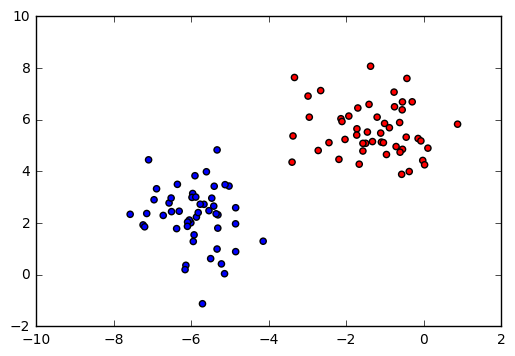

In [5]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr')

In [7]:
def plot_linear_classifier(x, y, w, b):
    x1_min, x1_max = x[:,0].min(), x[:,0].max()
    x2_min, x2_max = x[:,1].min(), x[:,1].max()

    x1, x2 = np.meshgrid(np.linspace(x1_min-1, x1_max+1,100), np.linspace(x2_min-1, x2_max+1, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T

    plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr')

    y_mesh = np.dot(x_mesh, w.T) + b
    y_mesh = np.where(y_mesh < 0.5, 0, 1)

    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap='bwr', alpha=0.5)
    plt.xlim(x1_min-1, x1_max+1)
    plt.ylim(x2_min-1, x2_max+1)

### Python

step 0: 50.4071095609273
step 100: 3.9740442436718864
step 200: 2.9860189722052617
step 300: 2.522655621117986
step 400: 2.305452288474261
step 500: 2.203709051714671
step 600: 2.156099254481804
step 700: 2.133854458988832
step 800: 2.1234842006419012
step 900: 2.118665689077481
step 1000: 2.1164378067636376
w:  [0.1402988414959151, 0.08073010510726389]
b:  0.6789418328000937


/Users/lucasosouza/anaconda/envs/udacity/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/lucasosouza/anaconda/envs/udacity/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


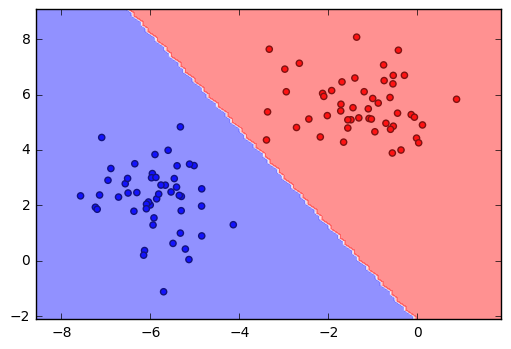

In [11]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)] # [1xD]
b = 2*random() - 1 # [1x1]

learning_rate = 1e-3 # <- tente estimar a learning_rate

for step in range(1001):
    cost = 0
    for x_i, y_i in zip(x, y):
        y_pred = sum([w[d]*x_i[d] for d in range(D)]) + b
        error = y_i[0] - y_pred
        w = [w[d] + learning_rate*error*x_i[d] for d in range(D)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%100 == 0:
        print('step {0}: {1}'.format(step, cost))

print('w: ', w)
print('b: ', b)

plot_linear_classifier(x, y, np.array(w), b)

### Numpy

step 0: [[583.82095325]]
step 100: [[5.0523474]]
step 200: [[3.49185451]]
step 300: [[2.75985968]]
step 400: [[2.41662729]]
step 500: [[2.25577558]]
step 600: [[2.18045609]]
step 700: [[2.14522978]]
step 800: [[2.12878383]]
step 900: [[2.12112579]]
step 1000: [[2.11757363]]
w:  [[0.13966826 0.08156049]]
b:  [[0.67310511]]


/Users/lucasosouza/anaconda/envs/udacity/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/lucasosouza/anaconda/envs/udacity/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


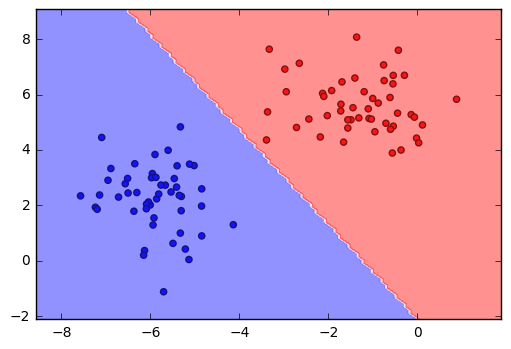

In [12]:
D = x.shape[1]
w = 2*np.random.random((1, D))-1
b = 2*np.random.random()-1       

learning_rate = 1e-3 # <- tente estimar a learning_rate

for step in range(1001):
    cost = 0
    for x_i, y_i in zip(x, y):
        x_i = x_i.reshape(1, D)
        y_pred = np.dot(x_i, w.T) + b 
        error = y_i - y_pred
        w = w + learning_rate*np.dot(error.T, x_i)
        b = b + learning_rate*error
        cost += error**2
    
    if step%100 == 0:
        print('step {0}: {1}'.format(step, cost))
    
print('w: ', w)
print('b: ', b)

plot_linear_classifier(x, y, w, b)

# Referências

- [http://sisne.org/Disciplinas/PosGrad/PsicoConex/aula6.pdf](http://sisne.org/Disciplinas/PosGrad/PsicoConex/aula6.pdf)
- [What is the difference between a Perceptron, Adaline, and neural network model?](https://www.quora.com/What-is-the-difference-between-a-Perceptron-Adaline-and-neural-network-model)
- [RNA – Adaline e Regra do Delta](http://www.barbon.com.br/wp-content/uploads/2013/08/RNA_Aula4.pdf)